In [1]:
using CSV, Tables, LinearAlgebra, Random, Gurobi, JuMP, DataFrames, Statistics, MLJ, Plots, Clustering, Distances

In [2]:
"""
J is the number of points/record in the dataset
I is the number of clusters
D is the dimensionality of the points (number of features)
"""

function generate_points(I,J,D, std, seed = 1234)
    Random.seed!(seed);
    X, yy = make_blobs(J, D; centers=I, cluster_std=std)
    points = Matrix(DataFrame(X));
    min = minimum(points, dims=1);
    max = maximum(points, dims=1);
    points = (points .- min) ./ (max .- min);
    return points
end

function manhattan_optimal_kmenas(points, I, J, D)
    
    model = JuMP.Model(Gurobi.Optimizer);

    set_optimizer_attribute(model, "TimeLimit", 300)

    @variable(model, gamma[1:J]);
    @variable(model, z[1:J, 1:I],Bin);
    @variable(model, mu[1:J, 1:I] >=0);
    @variable(model, r[1:J, 1:I] >=0);
    @variable(model, x[1:I, 1:D] >=0);
    @variable(model, y[1:J, 1:D, 1:I] >=0);

    @constraint(model, [j = 1:J], sum(z[j,:]) == 1);

    @constraint(model, [i=1:I, j=1:J, d=1:D], sum(y[j,d,i] for d=1:D) == r[j,i]);
    @constraint(model, [i=1:I, j=1:J, d=1:D], y[j,d,i] >= x[i,d] - points[j,d]);
    @constraint(model, [i=1:I, j=1:J, d=1:D], y[j,d,i] >= -(x[i,d] - points[j,d]));

    @constraint(model, [i=1:I, j=1:J], gamma[j]>= r[j,i]-mu[j,i]);

    @constraint(model, [i = 1:I, j = 1:J], 5(1-z[j,i]) >= mu[j,i]);

    @objective(model, Min, sum(gamma[j] for j=1:J));

    optimize!(model);

    return value.(x), [argmax(value.(z)[i,:]) for i = 1:J], value.(gamma)  # centers, assignments, obj_value
end

function euclidean_optimal_kmenas(points,  I, J, D)
    
    model = JuMP.Model(Gurobi.Optimizer);

    set_optimizer_attribute(model, "TimeLimit", 300)

    @variable(model, gamma[1:J]);
    @variable(model, z[1:J, 1:I], Bin);
    @variable(model, mu[1:J, 1:I] >=0);
    @variable(model, r[1:J, 1:I] >=0);
    @variable(model, x[1:I, 1:D] >=0);
    @variable(model, y[1:J, 1:D, 1:I] >=0);

    @constraint(model, [j = 1:J], sum(z[j,:]) == 1);

    @constraint(model, [i=1:I, j=1:J, d=1:D], sum(y[j,d,i] for d=1:D) == r[j,i]);
    @constraint(model,[i=1:I, j=1:J, d=1:D], [y[j,d,i]; x[i,d] - points[j,d]] in SecondOrderCone())

    @constraint(model, [i=1:I, j=1:J], gamma[j]>= r[j,i]-mu[j,i]);

    @constraint(model, [i = 1:I, j = 1:J], 5(1-z[j,i]) >= mu[j,i]);

    @objective(model, Min, sum(gamma[j] for j=1:J));

    optimize!(model);

    return value.(x), [argmax(value.(z)[i,:]) for i = 1:J], value.(gamma)  # centers, assignments, obj_value
end

function mean_silhouette_score(assignment, counts, points)
    distances = pairwise(SqEuclidean(), points')
    return mean(silhouettes(assignment, counts, distances))
end

mean_silhouette_score (generic function with 1 method)

In [15]:
#I,J,D = 3, 100, 2
#std = [1,2,3]

points = generate_points(3,100,2, [2,1,3]);
centroids, assignment, obj_value = manhattan_optimal_kmenas(points, 3,100,2);

Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-04
Set parameter TimeLimit to value 300
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2500 rows, 1606 columns and 6000 nonzeros
Model fingerprint: 0xc3bce281
Variable types: 1306 continuous, 300 integer (300 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+00]
Found heuristic solution: objective 53.4306285
Presolve removed 924 rows and 612 columns
Presolve time: 0.01s
Presolved: 1576 rows, 994 columns, 3852 nonzeros
Variable types: 694 continuous, 300 integer (300 binary)

Root relaxation: objective -5.431675e+01, 1023 iterations, 0.01 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl 

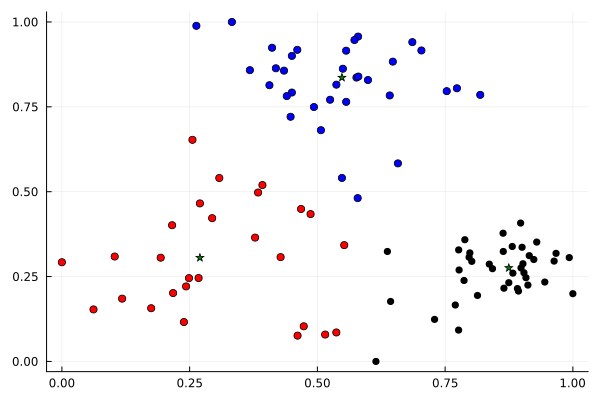

In [16]:
mapping = Dict(1=>:black, 2=>:red, 3=>:blue)
colors = [mapping[v] for v in assignment];

plot(points[:,1], points[:,2], seriestype=:scatter, legend=false, color=colors)
plot!(centroids[:,1], centroids[:,2], seriestype=:scatter, legend=false, color=:green, markershape=:star5)

In [17]:
centroids, assignment, obj_value = euclidean_optimal_kmenas(points, 3,100,2);

Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-04
Set parameter TimeLimit to value 300
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2500 rows, 2806 columns and 6000 nonzeros
Model fingerprint: 0x4b1602ac
Model has 600 quadratic constraints
Variable types: 2506 continuous, 300 integer (300 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+00]
Presolve removed 1022 rows and 1910 columns
Presolve time: 0.01s
Presolved: 1478 rows, 896 columns, 3888 nonzeros
Variable types: 596 continuous, 300 integer (300 binary)
Found heuristic solution: objective 44.5730438

Root relaxation: objective -2.801091e+02, 988 iterations, 0.01 seconds (0.02 work units)

    Node

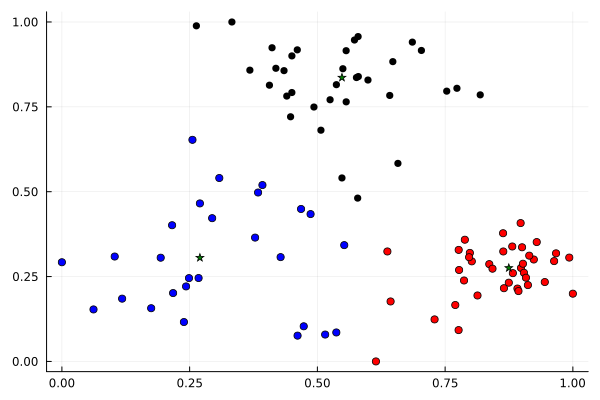

In [18]:
mapping = Dict(1=>:black, 2=>:red, 3=>:blue)
colors = [mapping[v] for v in assignment];

plot(points[:,1], points[:,2], seriestype=:scatter, legend=false, color=colors)
plot!(centroids[:,1], centroids[:,2], seriestype=:scatter, legend=false, color=:green, markershape=:star5)

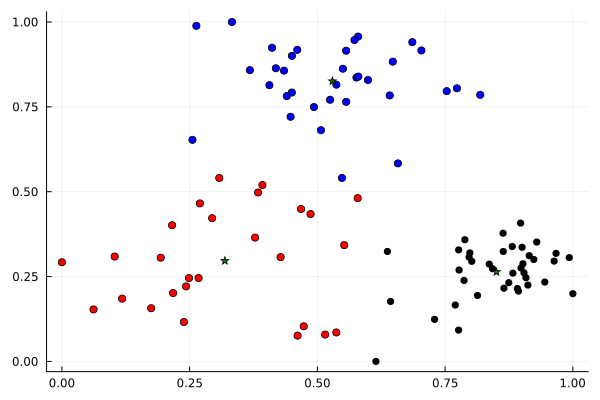

In [19]:
km = kmeans(points', 3);
centroids = km.centers';
assignments = km.assignments;

mapping = Dict(1=>:black, 2=>:red, 3=>:blue)
colors = [mapping[v] for v in assignments];

plot(points[:,1], points[:,2], seriestype=:scatter, legend=false, color=colors)

plot!(centroids[:,1], centroids[:,2], seriestype=:scatter, legend=false, color=:green, markershape=:star5)

#### Easy problem

In [29]:
points = generate_points(4,50,2, [0.8,1,0.5, 0.3]);
centroids,  assignment, obj_value = manhattan_optimal_kmenas(points, 4,50,2);

Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-04
Set parameter TimeLimit to value 300
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1650 rows, 1058 columns and 4000 nonzeros
Model fingerprint: 0x92e526e1
Variable types: 858 continuous, 200 integer (200 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-04, 5e+00]
Found heuristic solution: objective 43.1490128
Presolve removed 632 rows and 416 columns
Presolve time: 0.00s
Presolved: 1018 rows, 642 columns, 2536 nonzeros
Variable types: 442 continuous, 200 integer (200 binary)

Root relaxation: objective -3.065749e+01, 705 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Un

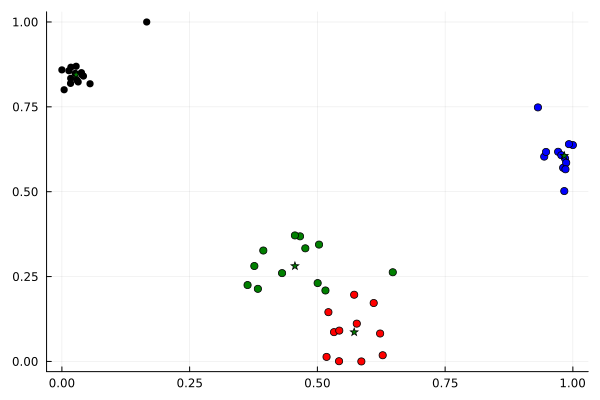

In [31]:
mapping = Dict(1=>:black, 2=>:red, 3=>:blue, 4=>:green)
colors = [mapping[v] for v in assignment];

plot(points[:,1], points[:,2], seriestype=:scatter, legend=false, color=colors)
plot!(centroids[:,1], centroids[:,2], seriestype=:scatter, legend=false, color=:green, markershape=:star5)

In [32]:
centroids, assignment, obj_value = euclidean_optimal_kmenas(points, 4,50,2);

Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-04
Set parameter TimeLimit to value 300
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1650 rows, 1858 columns and 4000 nonzeros
Model fingerprint: 0xd305cb78
Model has 400 quadratic constraints
Variable types: 1658 continuous, 200 integer (200 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-04, 5e+00]
Presolve removed 632 rows and 1216 columns
Presolve time: 0.00s
Presolved: 1018 rows, 642 columns, 2536 nonzeros
Variable types: 442 continuous, 200 integer (200 binary)
Found heuristic solution: objective 27.8005980

Root relaxation: objective -1.547645e+02, 642 iterations, 0.01 seconds (0.01 work units)

    Nodes

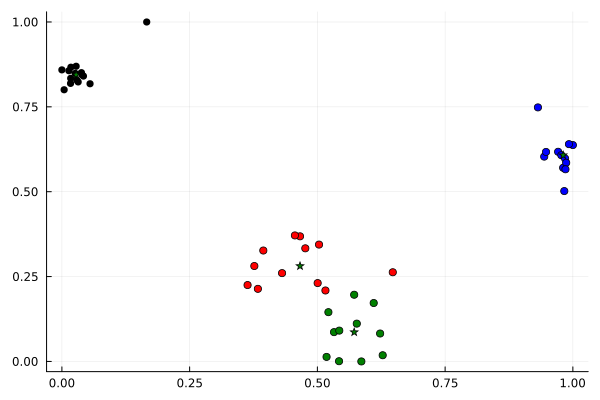

In [33]:
mapping = Dict(1=>:black, 2=>:red, 3=>:blue, 4=>:green)
colors = [mapping[v] for v in assignment];

plot(points[:,1], points[:,2], seriestype=:scatter, legend=false, color=colors)
plot!(centroids[:,1], centroids[:,2], seriestype=:scatter, legend=false, color=:green, markershape=:star5)

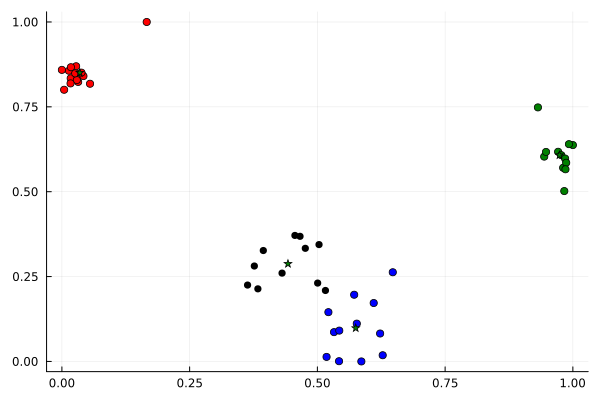

In [34]:
km = kmeans(points', 4);
centroids = km.centers';
assignments = km.assignments;
r = km.counts;

mapping = Dict(1=>:black, 2=>:red, 3=>:blue, 4=>:green)
colors = [mapping[v] for v in assignments];

plot(points[:,1], points[:,2], seriestype=:scatter, legend=false, color=colors)

plot!(centroids[:,1], centroids[:,2], seriestype=:scatter, legend=false, color=:green, markershape=:star5)

In [53]:
x = 1
for i = 1:4
    x += 1
end
x

5

In [58]:
counts([2,1,1,1,3])

3-element Vector{Int64}:
 3
 1
 1

### Results

In [3]:
euclidean = ones((4,1))
manhattan = ones((4,1))
x,y = 1,1

for point = [10,25,50,100]
    for clusters  = [2]
        points = generate_points(clusters,point,2, ones(clusters)*2);
        centroids,  assignment, obj_value = manhattan_optimal_kmenas(points, clusters,point,2);
        c = counts(assignment);
        manhattan[x,y] = mean_silhouette_score(assignment, c, points);
        centroids,  assignment, obj_value = euclidean_optimal_kmenas(points, clusters,point,2);
        c = counts(assignment);
        euclidean[x,y] = mean_silhouette_score(assignment, c, points);
        y+=1;
    end
    x+=1;
    y=1;
end

Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-04
Set parameter TimeLimit to value 300
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 170 rows, 114 columns and 400 nonzeros
Model fingerprint: 0x55cc5eb2
Variable types: 94 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 5e+00]
Found heuristic solution: objective 8.8139086
Presolve removed 86 rows and 58 columns
Presolve time: 0.00s
Presolved: 84 rows, 56 columns, 208 nonzeros
Variable types: 46 continuous, 10 integer (10 binary)

Root relaxation: objective 0.000000e+00, 50 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth

In [4]:
euclidean

4×1 Matrix{Float64}:
 0.8562550274904777
 0.8797974676017105
 0.8792504150207827
 0.8843775405547288

In [5]:
manhattan

4×1 Matrix{Float64}:
 0.8562550274904777
 0.8797974676017105
 0.8792504150207827
 0.8843775405547288

In [6]:
km = ones((4,1))
x,y = 1,1

for point = [10,25,50,100]
    for clusters  = [2]
        points = generate_points(clusters,point,2, ones(clusters)*2);
        centroids,  assignment,c = kmeans(points', clusters).centers, kmeans(points', clusters).assignments, kmeans(points', clusters).counts;
        dd = pairwise(SqEuclidean(), points')
        km[x,y] = mean(silhouettes(assignment, c, dd));
        y+=1;
    end
    x+=1;
    y=1;
end

In [7]:
km

4×1 Matrix{Float64}:
 0.8562550274904777
 0.880162058776181
 0.8792504150207827
 0.8843775405547288

In [8]:
euclidean = ones((4,1))
manhattan = ones((4,1))
km = ones((4,1))
x,y = 1,1

for point = [10,25,50,100]
    for clusters  = [3]
        points = generate_points(clusters,point,2, ones(clusters)*2);
        centroids,  assignment, obj_value = manhattan_optimal_kmenas(points, clusters,point,2);
        c = counts(assignment);
        manhattan[x,y] = mean_silhouette_score(assignment, c, points);
        centroids,  assignment, obj_value = euclidean_optimal_kmenas(points, clusters,point,2);
        c = counts(assignment);
        euclidean[x,y] = mean_silhouette_score(assignment, c, points);
        centroids,  assignment,c = kmeans(points', clusters).centers, kmeans(points', clusters).assignments, kmeans(points', clusters).counts;
        dd = pairwise(SqEuclidean(), points')
        km[x,y] = mean(silhouettes(assignment, c, dd));
        y+=1;
    end
    x+=1;
    y=1;
end

Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-04
Set parameter TimeLimit to value 300
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 250 rows, 166 columns and 600 nonzeros
Model fingerprint: 0xaa08eed5
Variable types: 136 continuous, 30 integer (30 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 5e+00]
Found heuristic solution: objective 7.9507399
Presolve removed 114 rows and 72 columns
Presolve time: 0.00s
Presolved: 136 rows, 94 columns, 342 nonzeros
Variable types: 64 continuous, 30 integer (30 binary)

Root relaxation: objective -5.255002e+00, 91 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  D

In [9]:
euclidean

4×1 Matrix{Float64}:
 0.5539103760243054
 0.757616359609759
 0.6910939757049167
 0.7630225036738796

In [10]:
manhattan

4×1 Matrix{Float64}:
 0.5539103760243054
 0.757616359609759
 0.6910939757049167
 0.7630225036738796

In [11]:
km

4×1 Matrix{Float64}:
 0.523548778358027
 0.7618320398549087
 0.694894343738803
 0.7406933696640204

In [24]:
euclidean = ones((4,1))
manhattan = ones((4,1))
km = ones((4,1))
x,y = 1,1

for point = [10,25,50,100]
    for clusters  = [4]
        points = generate_points(clusters,point,2, ones(clusters)*2);
        centroids,  assignment, obj_value = manhattan_optimal_kmenas(points, clusters,point,2);
        c = counts(assignment);
        manhattan[x,y] = mean_silhouette_score(assignment, c, points);
        centroids,  assignment, obj_value = euclidean_optimal_kmenas(points, clusters,point,2);
        c = counts(assignment);
        euclidean[x,y] = mean_silhouette_score(assignment, c, points);
        centroids,  assignment,c = kmeans(points', clusters).centers, kmeans(points', clusters).assignments, kmeans(points', clusters).counts;
        dd = pairwise(SqEuclidean(), points')
        km[x,y] = mean(silhouettes(assignment, c, dd));
        y+=1;
    end
    x+=1;
    y=1;
end

Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-04
Set parameter TimeLimit to value 300
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 330 rows, 218 columns and 800 nonzeros
Model fingerprint: 0xc0505345
Variable types: 178 continuous, 40 integer (40 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 5e+00]
Found heuristic solution: objective 9.5062215
Presolve removed 152 rows and 96 columns
Presolve time: 0.00s
Presolved: 178 rows, 122 columns, 456 nonzeros
Variable types: 82 continuous, 40 integer (40 binary)

Root relaxation: objective -6.646709e+00, 130 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj 

In [25]:
euclidean

4×1 Matrix{Float64}:
 0.651335739652738
 0.725022806234669
 0.6611273208339711
 0.6454493722373382

In [26]:
manhattan

4×1 Matrix{Float64}:
 0.651335739652738
 0.725022806234669
 0.8270339928617118
 0.6316013921772059

In [27]:
km

4×1 Matrix{Float64}:
 0.0024503633766460808
 0.2879754387125597
 0.26208361943421754
 0.6525044860660472

In [28]:
euclidean = ones((4,1))
manhattan = ones((4,1))
km = ones((4,1))
x,y = 1,1

for point = [200,300]
    for clusters  = [4]
        points = generate_points(clusters,point,2, ones(clusters)*2);
        centroids,  assignment, obj_value = manhattan_optimal_kmenas(points, clusters,point,2);
        c = counts(assignment);
        manhattan[x,y] = mean_silhouette_score(assignment, c, points);
        centroids,  assignment, obj_value = euclidean_optimal_kmenas(points, clusters,point,2);
        c = counts(assignment);
        euclidean[x,y] = mean_silhouette_score(assignment, c, points);
        centroids,  assignment,c = kmeans(points', clusters).centers, kmeans(points', clusters).assignments, kmeans(points', clusters).counts;
        dd = pairwise(SqEuclidean(), points')
        km[x,y] = mean(silhouettes(assignment, c, dd));
        y+=1;
    end
    x+=1;
    y=1;
end

Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-04
Set parameter TimeLimit to value 300
Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 6600 rows, 4208 columns and 16000 nonzeros
Model fingerprint: 0x235f85af
Variable types: 3408 continuous, 800 integer (800 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-03, 5e+00]
Presolve removed 2432 rows and 1616 columns
Presolve time: 0.02s
Presolved: 4168 rows, 2592 columns, 10336 nonzeros
Variable types: 1792 continuous, 800 integer (800 binary)
Found heuristic solution: objective 74.7209785

Root relaxation: objective -1.327763e+02, 2645 iterations, 0.06 seconds (0.11 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work


In [33]:
euclidean[1:2]

2-element Vector{Float64}:
 0.689160620684604
 0.6692531360351227

In [32]:
manhattan[1:2]

2-element Vector{Float64}:
 0.6748176495516414
 0.665727570941242

In [35]:
km[1:2]

2-element Vector{Float64}:
 0.511603943320127
 0.5064445951009521